In [1]:
import pandas as pd
import numpy as np

# Load Data

In [2]:
train = pd.read_csv("../data/train.csv")
val = pd.read_csv("../data/val.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
def text_length(data):
    data['text_length'] = data['text'].apply(lambda words: len(words.split(" ")))

In [4]:
text_length(train)
text_length(val)
text_length(test)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='text_length', ylabel='Count'>

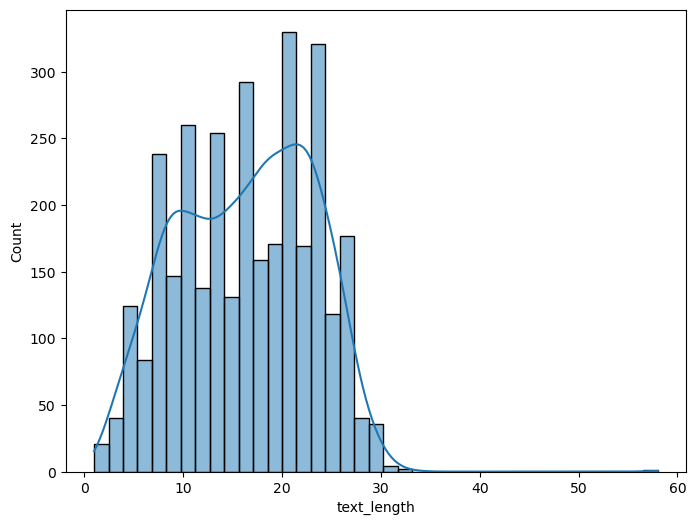

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=train, x='text_length', kde=True,ax=ax)

Text(0.5, 1.0, 'Test Emotion Distribution')

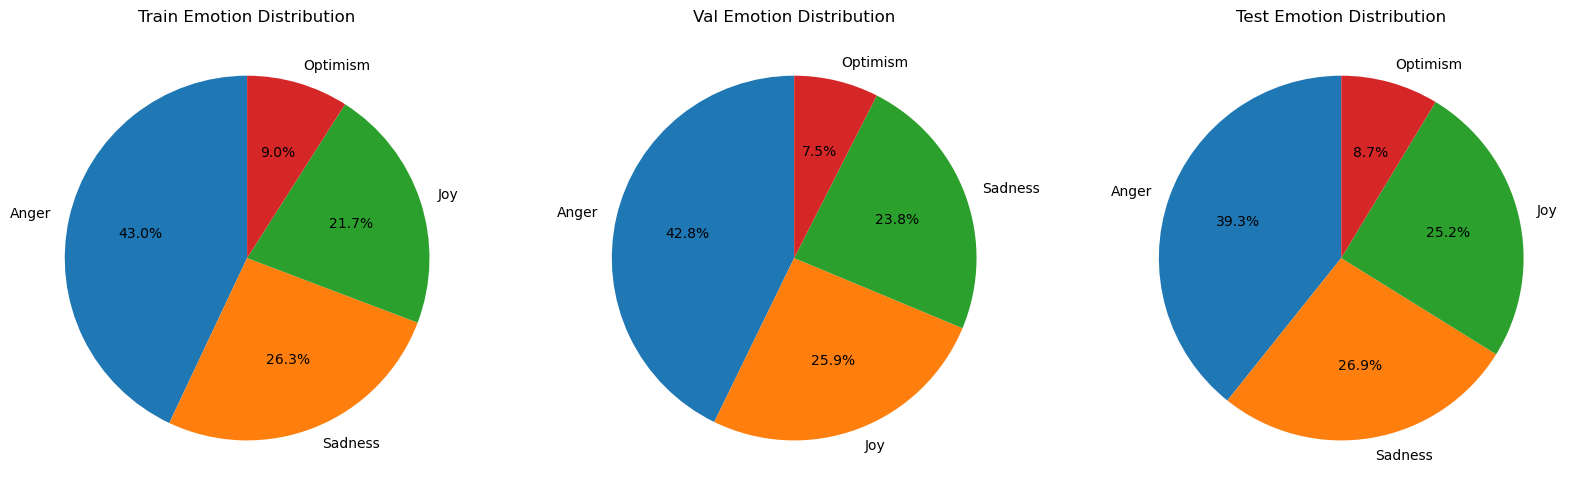

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,16))
axes[0].pie(train["emotion"].value_counts(),labels=train["emotion"].value_counts().index, autopct='%1.1f%%', startangle=90,)
axes[0].set_title(f"Train Emotion Distribution")

axes[1].pie(val["emotion"].value_counts(),labels=val["emotion"].value_counts().index, autopct='%1.1f%%', startangle=90,)
axes[1].set_title(f"Val Emotion Distribution")

axes[2].pie(test["emotion"].value_counts(),labels=test["emotion"].value_counts().index, autopct='%1.1f%%', startangle=90,)
axes[2].set_title(f"Test Emotion Distribution")

In [8]:
from data_preprocessor import DataPreprocessor

In [9]:
data_pre = DataPreprocessor()
train['processed'] = train['text'].apply(lambda x: data_pre(x))
val['processed'] = val['text'].apply(lambda x: data_pre(x))
test['processed'] = test['text'].apply(lambda x: data_pre(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yimin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def text_processed_length(data):
    data['processed_length'] = data['processed'].apply(lambda words: len(words.split(" ")))

In [11]:
text_processed_length(train)
text_processed_length(val)
text_processed_length(test)

In [12]:
train.head()

,text,label,emotion,text_length,processed,processed_length
0,“Worry is a down payment on a problem you may ...,2,Optimism,18,worry payment problem may never joyce motivati...,9
1,My roommate: it's okay that we can't spell bec...,0,Anger,14,roommate okay spell terrible,4
2,No but that's so cute. Atsu was probably shy a...,1,Joy,18,cute probably shy photo cherry help,6
3,Rooneys fucking untouchable isn't he? Been fuc...,0,Anger,13,fuck untouchable fuck dreadful look decent ton...,7
4,it's pretty depressing when u hit pan on ur fa...,3,Sadness,11,pretty depress hit pan favourite highlighter,6


# Model

## Deep Learning Model

In [13]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [14]:
train_text = train['processed'].tolist()
val_text = val['processed'].tolist() 
test_text = test['processed'].tolist() 

In [15]:
MAX_WORDS = 114514
tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(train_text)

In [16]:
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)
test_seq = tokenizer.texts_to_sequences(test_text)
text_index = tokenizer.word_index

In [17]:
MAX_TRAIN_TEXT_LENGTH = train["processed_length"].max()
train_seq = sequence.pad_sequences(train_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)
val_seq = sequence.pad_sequences(val_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)
test_seq = sequence.pad_sequences(test_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)

In [18]:
train_labels = np.eye(4)[train['label'].to_list()]
val_labels = np.eye(4)[val['label'].to_list()]
test_labels = np.eye(4)[test['label'].to_list()]

### Load Embedding Matrix

In [19]:
import codecs
from tqdm import tqdm

In [20]:
# code source: https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook
embeddings_index = {}
f = codecs.open('../model/crawl-300d-2M/crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

1999996it [07:50, 4251.82it/s]

found 1999996 word vectors


In [21]:
EMBEDDING_DIM = 300
WORDS_NUMBER = min(MAX_WORDS, len(text_index))

In [22]:
# code source: https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook
print('preparing embedding matrix...')
words_not_found = []
embedding_matrix = np.zeros((WORDS_NUMBER, EMBEDDING_DIM))
for word, i in text_index.items():
    if i >= WORDS_NUMBER:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 4


In [23]:
embedding_matrix = np.vstack([embedding_matrix, embedding_matrix[-1]])

In [24]:
BATCH_SIZE = 32
NUM_EPOCHS = 100 
NUM_FILTERS = 64 
NUM_GRU_UNITS = 128
WEIGHT_DECAY = 1e-4
NUM_HEADS = 2
NUM_CLASSES = 4

In [25]:
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, GRU, Bidirectional,MultiHeadAttention
from keras.layers import LeakyReLU
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

In [26]:
def network_classifer():
    
    input_layer = Input(shape=(MAX_TRAIN_TEXT_LENGTH,))
    
    embedding_layer = Embedding(WORDS_NUMBER+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_TRAIN_TEXT_LENGTH, trainable=False)(input_layer)
    
    
#     attention_output = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=64)(embedding_layer, embedding_layer,embedding_layer)
    
    conv_output = Conv1D(NUM_FILTERS, 16, activation=LeakyReLU(alpha=0.1), padding='same')(embedding_layer)
    maxpool_output = MaxPooling1D(2)(conv_output)

    
    gru_output = Bidirectional(GRU(NUM_GRU_UNITS, return_sequences=False))(maxpool_output)

    dropout_output = Dropout(0.1)(gru_output)

    
    dense_output_1 = Dense(128, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(dropout_output)
    dense_output_2 = Dense(64, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(dense_output_1)

    output_layer = Dense(NUM_CLASSES, activation='softmax')(dense_output_2)

    return Model(inputs=[input_layer], outputs=[output_layer])

In [28]:
model = network_classifer()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.005), metrics=['accuracy'])

C:\Users\yimin\anaconda3\envs\text_analytics\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\yimin\anaconda3\envs\text_analytics\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [29]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
validation_data = (val_seq, val_labels)

In [30]:
history = model.fit(train_seq, train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    callbacks=callbacks_list, 
                    validation_data=validation_data, 
                    shuffle=True, 
                    verbose=2)

Epoch 1/100
102/102 - 13s - 131ms/step - accuracy: 0.3909 - loss: 1.3720 - val_accuracy: 0.4278 - val_loss: 1.3361
Epoch 2/100
102/102 - 4s - 39ms/step - accuracy: 0.4298 - loss: 1.3189 - val_accuracy: 0.4278 - val_loss: 1.3051
Epoch 3/100
102/102 - 5s - 49ms/step - accuracy: 0.4298 - loss: 1.2964 - val_accuracy: 0.4278 - val_loss: 1.2892
Epoch 4/100
102/102 - 3s - 34ms/step - accuracy: 0.4298 - loss: 1.2833 - val_accuracy: 0.4278 - val_loss: 1.2794
Epoch 5/100
102/102 - 6s - 60ms/step - accuracy: 0.4298 - loss: 1.2745 - val_accuracy: 0.4278 - val_loss: 1.2714
Epoch 6/100
102/102 - 4s - 43ms/step - accuracy: 0.4298 - loss: 1.2643 - val_accuracy: 0.4278 - val_loss: 1.2625
Epoch 7/100
102/102 - 5s - 53ms/step - accuracy: 0.4298 - loss: 1.2517 - val_accuracy: 0.4278 - val_loss: 1.2511
Epoch 8/100
102/102 - 4s - 40ms/step - accuracy: 0.4302 - loss: 1.2378 - val_accuracy: 0.4278 - val_loss: 1.2368
Epoch 9/100
102/102 - 6s - 54ms/step - accuracy: 0.4320 - loss: 1.2176 - val_accuracy: 0.4305 

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 19, 300)             │       1,337,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 19, 64)              │         307,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,835,070 (7.00 MB)

 Trainable params: 497,668 (1.90 MB)

 Non-trainable params: 1,337,400 (5.10 MB)

 Optimizer params: 2 (12.00 B)

In [34]:
model.save("../model/deep-learning-model/BiGRU.keras")

In [36]:
result = model.predict(test_seq)

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
